# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

# Imports
Importing necessary libraries/modules.

In [1]:
# General
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from datetime import datetime, date, timedelta

In [2]:
# For prediction models
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Setting up all global variables for this notebook
It might be desirable to try out the analysis using different settings and feature selections. We tried to provide as many of changeable parameters below. You are welcome to play a bit with the parameters in the code block directly below. The other ones should not be changed except for debugging purposes 

In [3]:
# Analysis parameters:

# The number of days that should be looked ahead in the relation and predictive analysis:
daysAhead = 60
# the list of the column names of all kpis used. Changing this temporarily could serve kpi importance analysis although it might not be necessary because the descriptive logistic regression analysis already serves this aim:
kpis = ['new_cases_smoothed_per_tenthousand','reproduction_rate','highest_change_two_weeks','icu_patients_per_tenthousand','hosp_patients_per_tenthousand','weekly_icu_admissions_per_tenthousand',
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_people_vaccinated_smoothed_per_hundred']

# The list of KPIs that will not be used in predictive analytics even if they are used in descriptive analytics:
excludeFromPrediction = ['weekly_icu_admissions_per_tenthousand'] # Unfortunatly Japan does not provide weekly icu admission numbers and therefore we decided to exclude it from predictive analysis

# A list of the iso codes of the countries that will be used in the analysis. We choose the Netherlands (NLD), Italy (ITA) and Japan (JPN). Countries outside of this selection cannot be chosen here unless the data preperation
# code is changed to load this data. A subselection of these countries could be chosen here if one would only want to analyse this subsection:
ISO_filter = ['NLD','ITA', 'JPN']


In [4]:
# because of the way the sql database is designed column names should have the suffix _inter
excludeFromPrediction = [s+'_inter' for s in excludeFromPrediction]
kpis = [s+'_inter' for s in kpis]

In [5]:
# Technical or static parameters (No change should be needed in any of these):

# The names of all PER level label names, changing this shouldn't be necessary:
yLabels = ['No restrictions','> 1000 people','100-1000 people','10-100 people','< 10 people'] 
# The name of the SQL view or table containing all data as columns. Changing this should only be necessary if the name of this source is changed in the data preparation for any reason.
sql_sourcename = 'total_df'

# Setting up SQL communication and task specific formatting
Making a class responsible for communication with the SQL server containing all preprocessed data and making an object of that class for further use within this notebook

In [6]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [7]:
class SQL_reader:
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.db_conn = db_conn # The connection to the SQL server holding all information
        self.mainView = mainView # The name of the view or table holding all information
        self.ISO_filter = ISO_filter # A list of the iso codes of the countries filtered on in the current analysis
    def GetIsoDict(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method to load desired data in a dictionary with country iso codes as keys
        In: 
            kpiColNames: a list of the column names of the kpis which are to be extracted
            policyColName: the column name of the policy measure which is to be extracted 
            daysAhead: the number of days that should be between the values in the kpi lists and the corresponding future policy measure levels.
            Ultimatly this will be the number of days the analysis will look into the future.
        Out: 
            a dictionary with iso_code as key and a three-element tuple as value. Elements of the tuple:
                kpis: A list of list, 1 list for all values for the desired kpis (given in the kpiColNames-list). These lists contain all values for the given kpi and iso code specified in
                the dictionary key.
                futPolicy: a list of the chosen policy measure (standardly the PER level) N days after the same entry in the kpi-lists, where N is daysAhead
                indices: a list of original indices within the SQL table of all entries in the kpi lists.
        
        """
        isoDict = dict()
        for iso in self.ISO_filter:
            # Getting all desired KPI- and PER data in numpy arrays from the SQL database
            queryP2 = ' FROM ' + self.mainView + '\nWHERE ' "iso_code = '" + iso + "';"
            futPolicy = np.array(pd.read_sql('SELECT ' + policyColName + queryP2, self.db_conn)[policyColName])
            futPolicy = futPolicy[daysAhead:]
            indices = np.array(pd.read_sql('SELECT index' + queryP2, self.db_conn)['index'])
            indices = indices[:-daysAhead]
            kpis = []
            # Crops first N values from futPolicy array and N last values from KPI arrays where N = daysAhead. 
            for kpiColName in kpiColNames:
                kpi = np.array(pd.read_sql('SELECT ' + kpiColName + queryP2, self.db_conn)[kpiColName])
                kpi = kpi[:-daysAhead]
                kpis.append(kpi)
            toDelete = []
            #Delete all nan values such that all data is usable while keeping KPI (and indices) -> fut policy mapping intact:
            for i in range(len(futPolicy)):
                if futPolicy[i] == None or np.isnan(futPolicy[i]):
                    toDelete.append(i)
                    continue
                for kpi in kpis:
                    if kpi[i] == None or np.isnan(kpi[i]): 
                        toDelete.append(i)
                        break
            for i in range(len(kpis)):
                kpis[i] = np.delete(kpis[i],toDelete)
            futPolicy = np.delete(futPolicy,toDelete)
            indices = np.delete(indices,toDelete)
            isoDict[iso] = (kpis,futPolicy,indices)
        return isoDict
    
    def FormatColumns(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method to load desired data of all used countries into a single list
        In: 
            kpiColNames: a list of the column names of the kpis which are to be extracted
            policyColName: the column name of the policy measure which is to be extracted 
            daysAhead: the number of days that should be between the values in the kpi lists and the corresponding future policy measure levels.
            Ultimatly this will be the number of days the analysis will look into the future.
        Out: 
            a three tuple. Elements of the tuple:
                kpis: A list of list, 1 list for all values for the desired kpis (given in the kpiColNames-list). These lists contain all values for the given kpi and iso code specified in
                the dictionary key.
                futPolicy: a list of the chosen policy measure (standardly the PER level) N days after the same entry in the kpi-lists, where N is daysAhead
                indices: a list of original indices within the SQL table of all entries in the kpi lists.
        
        """
        # Get a list in the desired format per country:
        isoDict = self.GetIsoDict(kpiColNames,policyColName,daysAhead)
        
        # Merge all these lists for all iso codes
        kpis = []
        for i in range(len(list(isoDict.values())[0][0])):
            kpis.append([])
        policy = []
        indices = []
        for k, v in isoDict.items():
            kpiParts, policyPart, indicesPart = v
            for i in range(len(kpiParts)):
                kpis[i].extend(kpiParts[i])
            policy.extend(policyPart)
            indices.extend(indicesPart)
        return (kpis, policy,indices)
    
    def FindRecordsFromKPIs(self, kpiNames,kpiValues):
        """
        A function that returns a dataframe with the possible records of a partially known instance based on a list of known kpi values for this instance.
        In: 
            kpiNames: a list of the names of the kpis of which the value is known for the instance
            kpiValues: a list of the values of these kpis
        Out: 
            A pandas dataframe consisting of all possible records the instance might correspond to based on the kpi values.
        """
        query = 'SELECT * FROM ' + self.mainView + ' WHERE '
        for i in range(len(kpiNames)):
            query += kpiNames[i]+" = " + str(kpiValues[i]) + ' AND '
        if len(kpiNames) > 1:
            query = query[:-5]
        return pd.read_sql(query, self.db_conn)
    
    def FindRecordFromDateAndISO(self, date, ISO):
        """
        A function that returns the unique entry in the SQL database identified by a given date (date) and the iso_code of a country (ISO).
        The resulted record will be a pandas dataframe.
        """
        query = 'SELECT * FROM ' + self.mainView + " WHERE date = CAST('" + str(date) + "' AS DATE) AND iso_code = '" + ISO +"';"
        return pd.read_sql(query, self.db_conn)
    
    def FindRecordFromIndex(self, index):
        """
        A function that returns the unique entry in the SQL database identified by a given index.
        The resulted record will be a pandas dataframe.
        """
        query = 'SELECT * FROM '+ self.mainView + ' WHERE index = ' + str(index)
        return pd.read_sql(query, self.db_conn)
    
    def FindMostRecentRecordWithKPIs(self, kpiColNames, iso_code):
        """
        A function that finds and returns a pandas df containing the most recent record in of the country specified by iso_code that has a non-missing value for all columns specified in kpiColNames.
        """
        query = 'SELECT * FROM ' + self.mainView +'\nWHERE '
        for cn in kpiColNames:
            query += cn + ' IS NOT NULL AND '
        query += "iso_code = '" + iso_code + "';"
        return pd.read_sql(query, self.db_conn).tail(1)
        
    def GetMostRecentRecords(self, requiredColNames):
        """
        A function that finds and returns a pandas df containing the most recent records that have a non-missing value for all columns specified in kpiColNames for all countries in the iso filter.
        """
        mostRecents = []
        for iso in self.ISO_filter:
            mostRecent = sql_reader.FindMostRecentRecordWithKPIs(requiredColNames,iso)
            mostRecents.append(mostRecent)
        
        return pd.concat(mostRecents)

In [8]:
# Creating an SQL reader object to read from SQL database
sql_reader = SQL_reader(db_conn,sql_sourcename,ISO_filter)

# Descriptive within data type analysis

In [9]:
def boxplot(df, kpi):
    


    return


# Descriptive relational analytics
Here we provide a descriptive analysis of the relation between all KPIs and the public event restriction (PER) level in terms of Spearman's rho and scatterplots

In [10]:
class DescriptiveRelationAnalytics:
    """
    A class designed to perform descriptive analytics for the relation between
    all kpi's and our independent variable, being the public event restrictions (PER) level
    in place (an ordinal value with 5 levels).
    """
    def __init__(self, sql_reader):
        self.sql = sql_reader
    def KPI_policy_rho(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return Spearman's rank correlation coefficient, denoted as rho, 
        together with the corresponding p-value between given KPI measure and the PER level X days later, where X = daysAhead.
        """
        kpis, policy,_ = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        rho, p = spearmanr(kpi,policy)
        return (rho,p)
    
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14, yLabels = yLabels):
        """
        A method designed to plot the PER level against a given kpi X days earlier, where X = daysAhead, distinguishing between different countries.
        """
        isoDict = self.sql.GetIsoDict([kpiColName],policyColName,daysAhead)
        # Plotting all datapoints for all countries seperatly (distinguished by color) on same plot 
        for iso, v in isoDict.items():
            kpis, policy, _ = v
            kpi = kpis[0]
            plt.scatter(kpi,policy, marker = '.',alpha=0.2)
        # Set other plot settings such as labels, title, etc:
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        # Making a title in the format Y per KPI N days before in COUNTRIES
        title = policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before in '
        if len(self.sql.ISO_filter)==1:
            title += self.sql.ISO_filter[0]
        else:
            for iso in self.sql.ISO_filter[:-1]:
                title+= iso + ', '
            title = title[:-2]
            title += ' and ' + self.sql.ISO_filter[-1]
        plt.title(title)
        # Creating a legend which also shows the number of datapoints per category
        leg = [x + ' (N=' + str(len(isoDict[x][0][0])) + ')' for x in isoDict.keys()]
        plt.legend(leg, bbox_to_anchor=(1,1), loc="upper left")
        # Setting the right PER level labels
        plt.yticks(np.arange(5),yLabels)
        plt.show()

    def KPIs_policy_stats_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which provides and prints statistical data on the relation between a given list of KPIs and the PER level X days later, where X = daysAhead
        and plots their relation as well
        """
        for kpiName in kpiColNameList:
            print(kpiName)
            rho, p = self.KPI_policy_rho(kpiName,policyColName,daysAhead)
            print('Pearson Rho: ' + str(rho) +'\t' + 'p: ' + str(p))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
 
    
    

In [11]:
# Creating an desctipive relation analytics object to perform descr. analysis with.
DRanalytics = DescriptiveRelationAnalytics(sql_reader)

new_cases_smoothed_per_tenthousand_inter
Pearson Rho: -0.028511067835604885	p: 0.1331454075960118


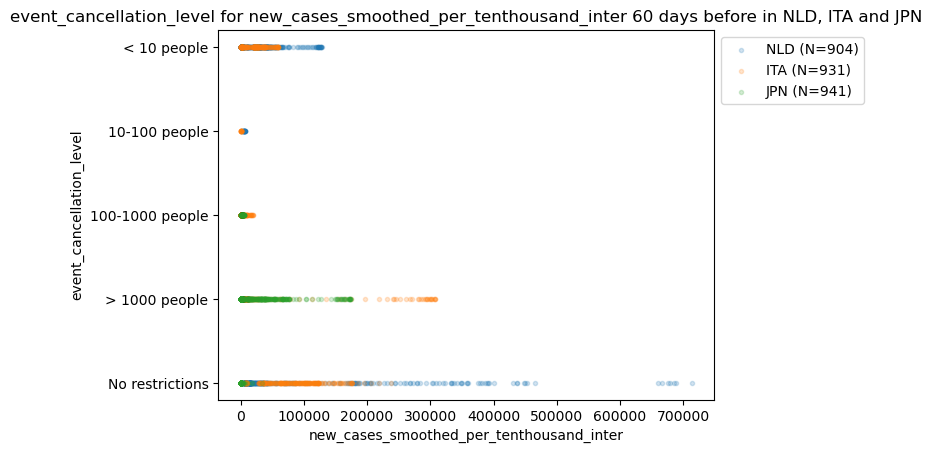

reproduction_rate_inter
Pearson Rho: 0.1541299276921967	p: 5.65831841244989e-16


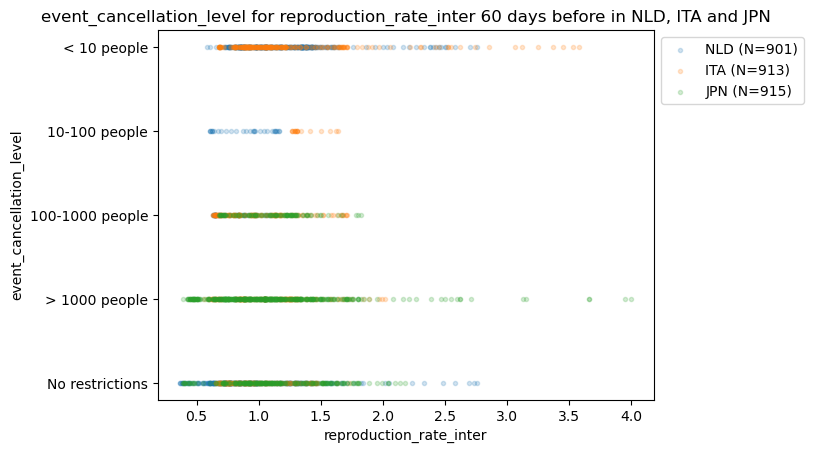

highest_change_two_weeks_inter
Pearson Rho: 0.031195253624070475	p: 0.11861571511817005


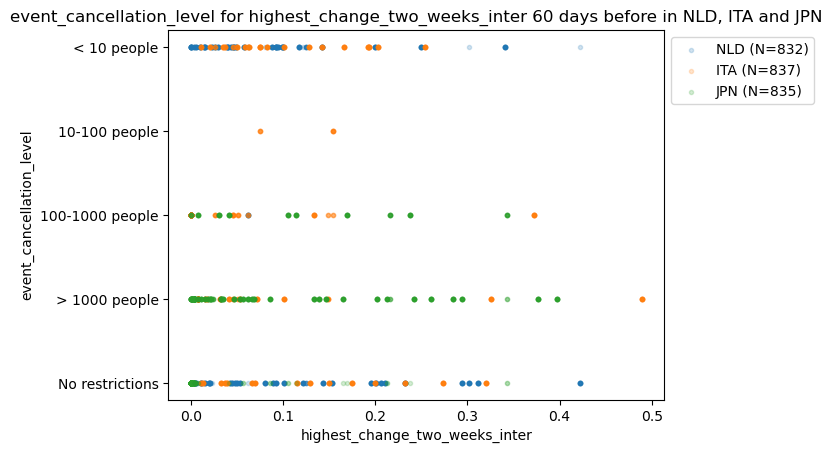

icu_patients_per_tenthousand_inter
Pearson Rho: 0.3393736926434781	p: 2.180390689442172e-73


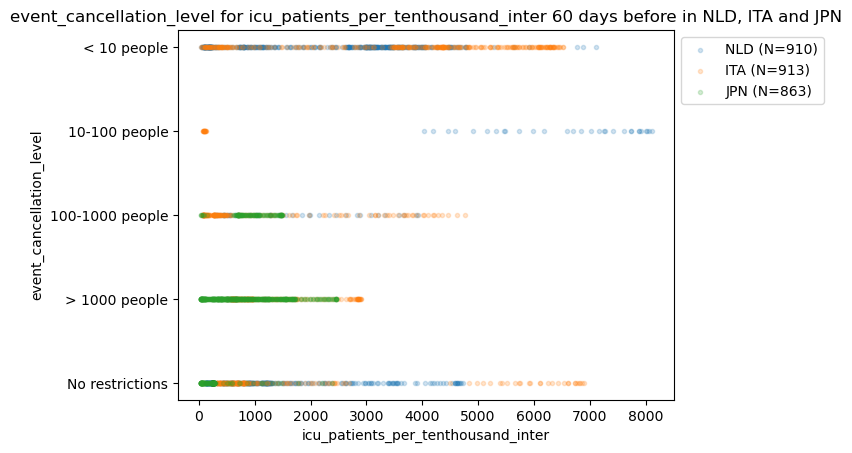

hosp_patients_per_tenthousand_inter
Pearson Rho: 0.1259970895544298	p: 5.235664135255876e-11


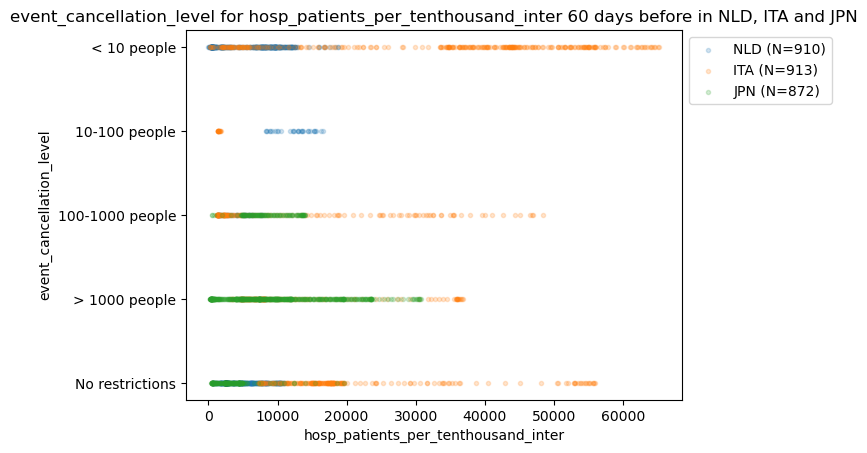

weekly_icu_admissions_per_tenthousand_inter
Pearson Rho: 0.6037770289928472	p: 9.768208486913764e-132


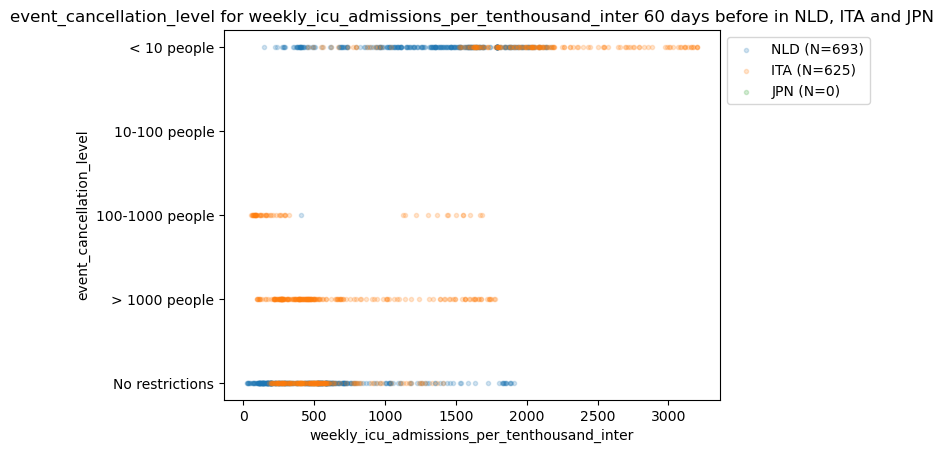

people_fully_vaccinated_per_hundred_inter
Pearson Rho: -0.37806771936192984	p: 3.669844522682012e-94


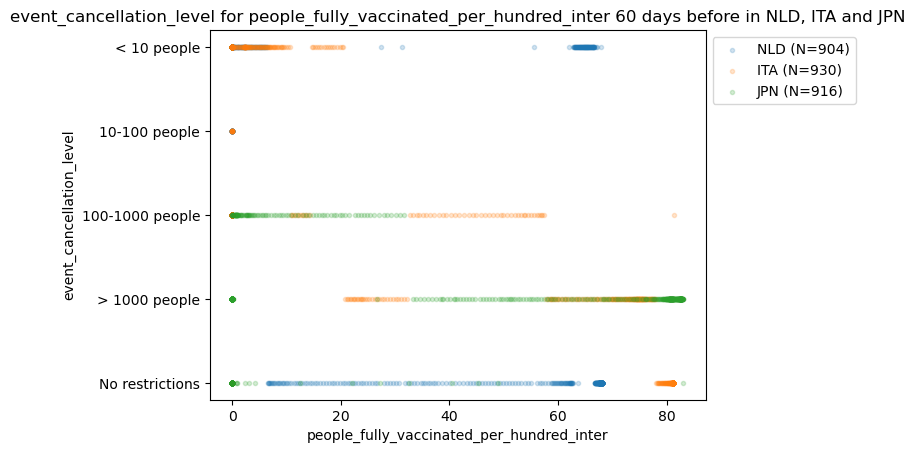

total_boosters_per_hundred_inter
Pearson Rho: -0.4620804911944898	p: 1.911751679727673e-107


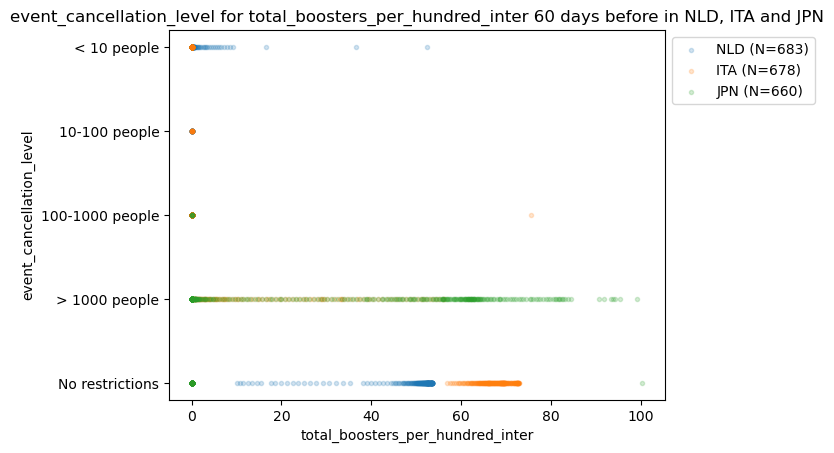

new_people_vaccinated_smoothed_per_hundred_inter
Pearson Rho: -0.00785457366415568	p: 0.6786320786987768


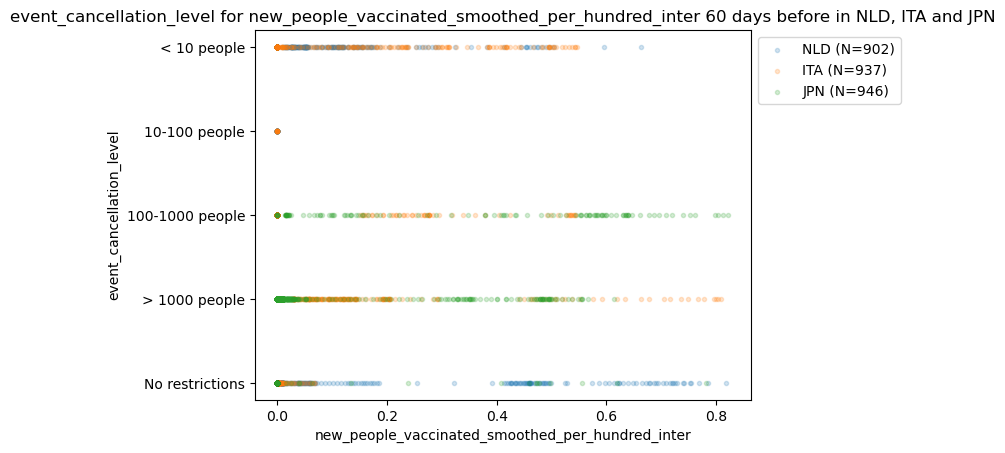

In [12]:
# Performing descr. rel. analysis
DRanalytics.KPIs_policy_stats_and_plots(kpis, daysAhead = daysAhead)

# Creating, training and testing predictive models
Here we set up ML models for predictive analysis and test them

In [13]:
class ML:
    """
    A class which contains functions that are helpful in using ML models in predictive analysis.
    """
    def score(model, X, Y, yLabels = yLabels):
        """
        A method to calculate and return the accuracy score and confusion matrix as pd dataframe of a given model (model) on a given feature matrix of size #samples X #features and 
        a correct answer array of size #samples.
        """
        # Setting up an all-zero confusion matrix (as dataframe) with TP, FP, TN, FN as columns and y-labels as rows:
        confusionDF = pd.DataFrame(yLabels)
        confusionDF.columns = ['y_labels']
        for col in ['TP','FP','TN','FN']:
            confusionDF[col] = np.zeros(len(confusionDF.index))
                                            
        right = 0
        # using given model to predict outcome for all samples in given testing data X:
        Y_hat = model.predict(X)
        for i in range(len(Y)):
            if Y_hat[i] == Y[i]: # if this condition is satisfied, the model prediction was correct for this instance
                right += 1
                # Adding a true positive to PER level Y[i]:
                confusionDF.at[int(Y[i]),'TP'] += 1
                # Adding a true negative to all other PER levels:
                for j in range(len(yLabels)):
                    if j != int(Y[i]):
                        confusionDF.at[j,'TN'] += 1
            else: # meaning y_hat is not equal to y, so the prediction was wrong for this instance
                # Adding a false negative to the PER level that should have been predicted:
                confusionDF.at[int(Y[i]),'FN'] += 1
                # Adding a false positive to the PER level that was predicted, but should not have been predicted:
                confusionDF.at[int(Y_hat[i]),'FP'] += 1
                # Adding true positives to the PER levels that should not have been predicted and were not predicted either:
                for j in range(len(yLabels)):
                    if not j  in [int(Y[i]), int(Y_hat[i])]:
                        confusionDF.at[j,'TN'] += 1
        #Adding a row containing the sum of each columns to the dataframe:
        confusionDF.loc[len(confusionDF.index)] = ['Total']+ list(confusionDF[confusionDF.columns[1:]].sum(axis=0))
        return right/len(Y), confusionDF
    
    def GetLogRegImportanceWeighting(LRmodel, featureNames, yLabelNames = yLabels):
        """
        A method that extracts the class specific feature weights from a trained logistic regression model and calculates the (normalized) sum of these absolute weights 
        per feature signifying the importance of each feature in decision making. The output is a pandas dataframe with features as columns and their weights as values. 
        (See the section on using logistic regression for descriptive analysis in this notebook).
        NOTE: these feature weights are only meaningful when the features were normalized before the logistic regression algorithm was trained on them.
        """
        coef = LRmodel.coef_ # this attribute contains the feature weights for all classes in a np array. See: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        # if there are only 2 classes and hence coef.shape[0] == 0 then only the weights for 1 class is given and hence we need to do away with one of our rows as done below:
        if coef.shape[0] == 1:
            yLabelNames = yLabelNames[:1]
        featImportance = np.sum(np.absolute(coef),axis=0) # taking the absolute sum of the feature weights to get the importance of each feature. Absolute sum is taken to ensure negative and positive contributions do not cancel each other out
        # adding a row with normalized absolute feature weight sum:
        totalFI = np.sum(featImportance)
        normFeatImp = featImportance/totalFI
        df = pd.DataFrame(np.r_[coef,[featImportance, normFeatImp]])
        #making dataframe more readable by adding sensible row and column names
        df.columns = featureNames
        rows = [x for x in yLabelNames]
        rows += ['Total absolute decision weight', 'Normalized total decision weight']
        df.index = rows
        return df

In [14]:
class MajorityBaseline:
    """
    A class to make, train, use and evaluate a baseline classifier simply returning the most frequent y label for each x input.
    """
    def __init__(self):
        self.choice = 0
    def fit(self,X,Y):
        """
        Fitting the model by finding the most frequent y-label (or one of them in case of equal frequency between different labels) and storing it.  
        """
        # Making an empty frequency (/count) list:
        N = len(np.unique(Y))
        Count = []
        for i in range(N):
            Count.append(0)
        # Finding the frequency of each y-label
        for y in Y:
            for i in range(N):
                if y == i:
                    Count[i] += 1
                    break
        # Finding the maximum frequency:
        maxCount = max(Count)
        # Storing the (first) y-label which has this maximum frequency as optimal choice for this model.
        self.choice = [i for i in range(len(Count)) if Count[i]==maxCount][0]
    def predict(self, X):
        """
        Predicting all samples x in X by simply returning the stored most frequent y-label regardless of x.
        Returning a 1 dimensional numpy array Y with the number of samples in X as length.
        """
        return np.array([self.choice for x in X])
    def score(self, X, Y):
        """
        Testing the model on test set X and corresponding y-labels Y. Returning accuracy.
        """
        res, _ = ML.score(self, X, Y)
        return res

In [15]:
class KClosestNeighborsBaseline:
    """
    A class to make, train, use and evaluate a baseline classifier simply returning the most frequent y label among the k
    instances in X closest to a given x. In this context close is not the same as near, so this is not a K nearest neighbor model.
    Instead with x1 and x2 being close I mean that in the original dataset X (containing both testing and training data) they were close so X[i+1] and X[i-1] would be closest
    to any X[i]. Because our training data is ordered by country and within single countries order by date, close data points usualy represent
    data from the same time period and the same country (the only exception being datapoints at the strart and end of each country section in the data).
    
    Because close datapoints are likely to be similair both in x-features (kpis) a KNN algorithm is likely to select these as nearest neighbors and because
    these close datapoints also tend to have the same y-labels (PER) levels, the KNN algorithm is likely to be correct. Hence this KCN algorithm can help
    determining whether high KNN accuracy is a result of near neighbors being close neighbors being similair in y labels (this is not what we would desire) or 
    whether high KNN accuracy show a direct relation between x-features and y-labels.
    
    NOTE: because this algorithm takes the position of x in X into account it only works as a baseline for accuracy testing in a complete dataset X. 
    It does not work for predicting y for any new x outside of X.
    """
    def __init__(self, k, X_complete,Y_complete):
        """
        This model requires access to the complete dataset including both testing and training data (see the class description)
        """
        self.k = k
        self.X = X_complete
        self.Y = Y_complete
    def fit(self,X,Y):
        """
        Training this model comes down to storing the subset of indices of the complete X set that were in the training set and 
        can therefore be used for prediction.
        """
        self.Itrain = [i for i in range(len(self.X)) if self.X[i] in X]
        
    def predict(self, X):
        """
        For each x to be predicted returns the closest x' in X.
        See class description for an explaination of closeness.
        """
        Y = []
        for x in X:
            Y.append(self.__predict_single_item(x))
        return np.array(Y)
    def __predict_single_item(self, x):
        """
        returns the closets x' in X to given x.
        See class description for an explaination of closeness.
        """
        ix = [i for i in range(len(self.X)) if np.array_equal(self.X[i],x)][0] # ix is the index of instance x in the complete data set X or the first of these indices if X contains identical x instances
        i = 1
        nbs = []
        # gradually increase the number of indices to look before or beyond x to make a list nbh of the closest instances:
        while len(nbs) < self.k:
            if ix + i in self.Itrain and ix + i < len(self.X):
                nbs.append(ix+i)
            if len(nbs) < self.k and ix - i in self.Itrain and ix-i >= 0:
                nbs.append(ix-i)
            i += 1
        # Getting the y-level of all closest instances
        Ynbh = [self.Y[i] for i in nbs]
        # Finding the most frequent among these y-labels and returning it:
        freqDict = dict()
        for y in np.unique(Ynbh):
            freqDict[y] = 0
        for y in Ynbh:
            freqDict[y] += 1
        maxFreq = max(list(freqDict.values()))
        return [y for y in freqDict.keys() if freqDict[y]==maxFreq][0]
    def score(self, X, Y):
        """
        Testing the model on test set X and corresponding y-labels Y. Returning accuracy.
        """
        res, _ = ML.score(self, X, Y)
        return res

In [16]:
class PredictiveAnalytics:
    """
    This class is used for transforming the data from the SQL server into a format supported by most ML models.
    It stores the processed data together with the index of each processed data point in the original SQL table/view it was derived from,
    so that it can be found again.
    """
    def __init__(self, sql_reader,selectedKPIs, policyColName = 'event_cancellation_level', daysAhead = 14):
        
        self.sql = sql_reader
        self.KPIs = selectedKPIs
        XT, Y, indices = self.sql.FormatColumns(self.KPIs,policyColName,daysAhead)
        XT =np.array(XT) 
        # Note: array XT now has shape (n_features, n_samples) which is the opposite (transpose) of the shape we desire for X as input for most ML models...
        # ... However, this shape is convenient for normalizing over features, which is why we will only transpose XT to X after this process of normalizing. 
        Y = np.array(Y)
        
        # Normalizing XT over features such that both the mean and sample standard deviation of any feature over all samples will be 0.5:
        M = []
        S = []
        for cx in XT:
            M.append([np.mean(cx)])
            S.append([np.std(cx,ddof=1)])
        M = np.array(M)
        S = np.array(S)
        XT = ((XT - M)/S+1)/2 
        
        # Getting X in the desired shape (n_samples, n_features):
        X=XT.T

        self.M=M # an 1D array (of shape (n_features)) containing the mean of values of each feature
        self.S=S # an 1D array (of shape (n_features)) containing sample standard deviation of each feature
        self.X = X # a 2D array of shape (n_samples, n_features) containing all features of all samples
        self.Y = Y # a 1D array of shape (n_samples) containing the y-class of all samples as a number 
        self.Indices = indices  # a 1D array of shape (n_samples) containing the index of each sample in the SQL table/view the data originally comes from.
        self.DaysAhead = daysAhead # an integer representing how many days value i in self.Y is ahead of sample i in self.X
    
        
    def NormalizeCostumX(self,X, transposed = False):
        """
        This method normalizes a given sample collection X based on the stored mean and sample standard deviation of all data that the object read from the
        SQL server when initializing. The method assumes the inputted X array has shape (n_samples, n_features) unless the parameter transposed is True, in which
        case the assumed shape is (n_features, n_samples).
        """
        # For ease of calculation we use the array XT with shape (n_features, n_samples)
        XT = X.T 
        if transposed:
            XT = X
        XT = ((XT - self.M)/self.S+1)/2
        return XT.T #the returned normalized array will be of shape (n_samples, n_features) 
        
    
    def TestModels(self, modelDict, yLabels=yLabels):
        """
        Testing all models in the modelDict (keys are modelnames and values are untrained models) by calculating
        their accuracy scores and a confusion matrix and returning a score dict (keys are modelnames and values are 
        (score, confusion matrix data frame)-pairs).
        """
        # Split into training and test set. For documentation of this method see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size = 0.2, random_state=42)
        # making a dictionary with the given modelnames as keys and a (score, confusion matrix data frame)-pair as values.
        scoreDict = dict()
        for key, value in modelDict.items():
            value.fit(X_train, Y_train)
            scoreDict[key] = ML.score(value,X_test,Y_test, yLabels)
        return scoreDict
    
    def GetSQLIndicesOfx(self, x):
        """
        A method to find and return a list containing the indices or index within the original SQL view or table the data 
        of a normalized x instance containing only the selected feature set.
        """
        res = [self.Indices[i] for i in range(len(self.Indices)) if X[i] == x]
        return res
    
    def GetSQLIndexFromInternalIndex(self, index):
        """
        A method which takes as input the index of an X instance within the dataset X as stored within this class 
        and gives as output the index of this instance in the original SQL view or table the data came from.
        """
        return self.Indices[index]
    

    def dfToNormalizedX(self, df):
        """
        A method that takes a pandas dataframe containing one or several datapoints (sets of among others kpis with their names as columns) 
        and returns a normalized X-array representation of the features of these datapoints.
        """
        X = df[self.KPIs].to_numpy()
        return self.NormalizeCostumX(X)
    
    
    
        

In [17]:
# As explained in the global variable section of this notebook, it might be desirable to exclude some KPIs which were in descriptive... 
#...analysis from predictive analysis. The selectedKPIs list contains all KPIS that will be used in predictive analysis.
selectedKPIs = [ x for x in kpis if x not in excludeFromPrediction ]

# Initializing a predictive analytics class
PrAn = PredictiveAnalytics(sql_reader,selectedKPIs,daysAhead=daysAhead)

In [19]:
# This code prints the distribution of y-labels within the data that is available for training and testing the ML models... 
#...(the data of the filtered countries for which data on all KPIs and PER level is available). Some y-label classes...
#... will be empty for certain ISO-filters. We will store the per levels of these classes and the labels of non-empty classes...
#...in order to avoid bugs resulting from empty classes.

#N is the list of the frequency  of per-level labels where the index of the list stands for the PER-level
N = [0,0,0,0,0]
for y in PrAn.Y:
    for i in range(5):
        if y == i:
            N[i] += 1
            break
print('Y data distribution:')
for i in range(5):
    print(str(i) + ': ' + str(N[i]))

emptyClasses = [i for i in range(len(yLabels)) if N[i] == 0] # This list contains the PER level (an integer between 0 and 4) which do not occur in the filtered data set
yLabelSelection = [yLabels[i] for i in range(len(yLabels)) if i not in emptyClasses] # This list contains the PER-labels (strings) of the y-labels that DO occur in the filtered data set


Y data distribution:
0: 620
1: 513
2: 133
3: 17
4: 449


In [30]:
# Here we initialize different ML models, among which the baseline models introduced above.
modelDict = dict()
modelDict['logistic regression model'] = LogisticRegression() # This model is imported from the sklearn module...
#... for documentation see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#the KNC method below is short for the KNeighborsClassifier imported from the sklearn module...
#... for documentation see: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
modelDict['knn model (k=1)'] =  KNC(n_neighbors = 1)
modelDict['knn model (k=2)'] =  KNC(n_neighbors = 2)
modelDict['knn model (k=5)'] = KNC(n_neighbors = 5)
modelDict['kcn baseline (k=1)'] = KClosestNeighborsBaseline(1,PrAn.X,PrAn.Y)
modelDict['kcn baseline (k=5)'] = KClosestNeighborsBaseline(5,PrAn.X,PrAn.Y)
modelDict['kcn baseline (k=10)'] = KClosestNeighborsBaseline(10,PrAn.X,PrAn.Y)
modelDict['Majority baseline'] = MajorityBaseline()


In [31]:
# Here we train and test all models initialized above and print the results

x = PrAn.TestModels(modelDict, yLabels)
for k, v in x.items():
    s, cdf = v
    print(k +':',s)
for k, v in x.items():
    s, cdf = v
    print()
    print(k)
    print(cdf)

logistic regression model: 0.7521613832853026
knn model (k=1): 0.9481268011527377
knn model (k=2): 0.9481268011527377
knn model (k=5): 0.9365994236311239
kcn baseline (k=1): 0.9711815561959655
kcn baseline (k=5): 0.9740634005763689
kcn baseline (k=10): 0.9769452449567724
Majority baseline: 0.40057636887608067

logistic regression model
          y_labels     TP    FP      TN    FN
0  No restrictions  116.0  38.0   170.0  23.0
1    > 1000 people   63.0  15.0   238.0  31.0
2  100-1000 people    7.0   6.0   319.0  15.0
3    10-100 people    0.0   0.0   342.0   5.0
4      < 10 people   75.0  27.0   233.0  12.0
5            Total  261.0  86.0  1302.0  86.0

knn model (k=1)
          y_labels     TP    FP      TN    FN
0  No restrictions  134.0   9.0   199.0   5.0
1    > 1000 people   92.0   1.0   252.0   2.0
2  100-1000 people   16.0   3.0   322.0   6.0
3    10-100 people    4.0   2.0   340.0   1.0
4      < 10 people   83.0   3.0   257.0   4.0
5            Total  329.0  18.0  1370.0  18.0



# Using of logistic regression (LR) model for DESCRTIPTIVE analysis
Not only can the trained LR model be used for predictive analysis, looking at the weights it learns per KPI feature also provides insightfull information for descriptive analysis. The table below shows how much weight was assigned to each KPI for predicting each PER-level label and the (normalized) sum of these absolute weights, which tells us about the overal usefulness of these KPIs for predicting the PER-level.

Note: the only reason these weights are meaningful is because I normalized all features before using them in the LR model (mean 0.5, sd 0.5).

In [21]:
# Here we show a dataframe for using the logistic regression model for descriptive analytics. See the description above...
#... and the GetLogRegImportanceWeighting function in the ML class written above for further explaination
LRmodel = modelDict['logistic regression model'] 
ML.GetLogRegImportanceWeighting(LRmodel, selectedKPIs, yLabelNames = yLabelSelection)


,new_cases_smoothed_per_tenthousand_inter,reproduction_rate_inter,highest_change_two_weeks_inter,icu_patients_per_tenthousand_inter,hosp_patients_per_tenthousand_inter,people_fully_vaccinated_per_hundred_inter,total_boosters_per_hundred_inter,new_people_vaccinated_smoothed_per_hundred_inter
No restrictions,3.371560,-1.037061,-0.345823,-1.185153,-1.137870,0.310892,3.605683,-1.799752
> 1000 people,-2.109177,0.829864,-0.470782,-1.941765,3.292671,2.567744,1.714426,1.311473
100-1000 people,-1.134111,-2.020867,-1.213485,0.632512,-0.404701,-1.243142,-0.390925,-0.700477
10-100 people,-0.239337,1.130241,1.240620,-1.026310,-0.718425,-1.050894,-0.194655,-0.231304
< 10 people,0.111066,1.097823,0.789470,3.520715,-1.031676,-0.584599,-4.734529,1.420060
Total absolute decision weight,6.965251,6.115856,4.060179,8.306455,6.585343,5.757271,10.640218,5.463066
Normalized total decision weight,0.129241,0.113480,0.075337,0.154127,0.122191,0.106827,0.197430,0.101368


# Current prediction pipeline
Here we used the trained logistic regression model to make predictions about the future public event restriction (PER) levels in our chosen countries.

In [33]:
class DailyPredictor:
    """
    This class is responsible for giving an prediction that is as up-to-date as possible based on the most
    recent complete data point for each country (being the data point containing values for all KPIs required to make a prediction).
    
    Note: the number of days this predictor looks ahead is determined by the daysAhead-parameter initially used 
    to initialize the sql_reader, which is used by the predictive analytics object this predictor uses and which was used
    to train the LRmodel. For each country this number is added to the date of the most recent complete data point.
    """
    def __init__(self, LRmodel, predictiveAnalytics):
        """
        Objects of this class need a logistic regression model (LRmodel) to make predictions and a
        predictive analytics object (predictiveAnalytics) to transform data to the desired format.
        """
        self.lrm = LRmodel
        self.pran = predictiveAnalytics
        self.mostRecents=self.pran.sql.GetMostRecentRecords(self.pran.KPIs) # This is a dataframe containing the most...
        #... recent record for all countries containing values for all KPIs required to make a prediction.
    def Predict(self, iso_filter = ['NLD','ITA','JPN'], returnAsLabel = True, yLabels = yLabels):
        """
        This function predicts and returns the most likely future y-level for the most recent complete datapoints 
        of all selected countries. If returnAsLabel is True the result will be in a string explaining the predicted
        future y-label (e.g. 'No restrictions') otherwise a number (0-4) corresponding to the PER-Level will be returned.
        The returned result will be a dictionary with ISO codes as keys and (y-value/label, date for which prediction holds)-pairs
        as values.
        """
        yLabels = [x for x in  yLabels] # make a copy of the yLabel-list in order not to modify it accidently
        preds = dict()
        for iso in iso_filter:
            x = self.mostRecents.loc[self.mostRecents['iso_code']==iso] # Get the most recent complete datapoint for the country specified by iso_code
            y = self.lrm.predict(self.pran.dfToNormalizedX(x))[0] # Predict the y-value for this datapoint.
            if returnAsLabel:
                y = yLabels[int(y)] # transform the numeric y-value into a label (string) if this is desired
            preds[iso] = y, self.GetPredictionTargetDate(iso)
        return preds
    def PredictProba(self, yLabels = yLabels):
        """
        This function predicts the likelihood of all y-levels in the future for the most recent complete datapoints 
        of all selected countries. The returned result will be a dataframe in which the rows represent countries
        and the columns represent the iso_code of these countries, the probabilities of different future y-labels,
        the dates for which these predictions hold and the number and labels of the most likely y-values.
        """
        yLabels = ['Probability for ' + x.lower() for x in yLabels]
        x = self.pran.dfToNormalizedX(self.mostRecents)
        arr = self.lrm.predict_proba(x)
        df = pd.DataFrame(arr)
        df.columns = yLabels
        df.index = self.mostRecents['iso_code']
        targets = [self.GetPredictionTargetDate(x) for x in df.index]
        df['Predicted for'] = targets
        df['Predicted PER level'] = [x for x,_ in self.Predict(df.index,False).values()]
        df['Predicted PER label'] = [x for x,_ in self.Predict(df.index,True).values()]
        return df
    def GetPredictionTargetDate(self, iso_code):
        """
        A method that finds and returns the date for which the prediction of the coubntry specified by iso_code
        holds by taking the date of the most recent complete data point and adding the number of days the LR model is
        trained to look ahead to that.
        """
        return self.mostRecents.loc[self.mostRecents['iso_code']==iso_code]['date'].iloc[0] + timedelta(days = self.pran.DaysAhead)

In [23]:
# This code finds and prints the date of the most recent complete datapoints for each country
dp = DailyPredictor(LRmodel, PrAn)
print('Most recent complete entries:')
for i in range(len(dp.mostRecents.index)):
    iso = dp.mostRecents['iso_code'].iloc[i]
    date = dp.mostRecents['date'].iloc[i]
    print(iso + ':', date.date())

Most recent complete entries:
NLD: 2022-09-02
ITA: 2022-10-10
JPN: 2022-09-26


In [24]:
# This code predicts the comming PER-level for all countries
print('Predicted comming event restrictions:')
preds = dp.Predict(ISO_filter)
for k, v in preds.items():
    y, date = v
    print(k + ':', y,'\t(This prediction is for', str(date.date()) + ')' )

Predicted comming event restrictions:
NLD: No restrictions 	(This prediction is for 2022-11-01)
ITA: No restrictions 	(This prediction is for 2022-12-09)
JPN: No restrictions 	(This prediction is for 2022-11-25)


In [25]:
predictions = dp.PredictProba(yLabels = yLabelSelection)
predictions

,Probability for no restrictions,Probability for > 1000 people,Probability for 100-1000 people,Probability for 10-100 people,Probability for < 10 people,Predicted for,Predicted PER level,Predicted PER label
iso_code,,,,,,,,
NLD,0.800430,0.196615,0.002779,0.000142,3.297632e-05,2022-11-01,0.0,No restrictions
ITA,0.800549,0.199340,0.000085,0.000024,1.642526e-06,2022-12-09,0.0,No restrictions
JPN,0.854705,0.145186,0.000105,0.000003,6.929487e-08,2022-11-25,0.0,No restrictions


# To SQL
Getting the prediction results to SQL. It will be in a table called predictions.

In [26]:
cols = ['prob' + str(i) for i in range(len(yLabels)) if i not in emptyClasses]
predictions.columns = cols + ['pred_date','per_level','per_label']
for i in emptyClasses:
    predictions['prob' + str(i)] = np.zeros(len(predictions.index))
db_conn.execute("DROP TABLE IF EXISTS predictions CASCADE;")
predictions.to_sql('predictions',db_conn)
df = pd.read_sql('SELECT * FROM predictions',db_conn,)
df

,iso_code,prob0,prob1,prob2,prob3,prob4,pred_date,per_level,per_label
0,NLD,0.800430,0.196615,0.002779,0.000142,3.297632e-05,2022-11-01,0.0,No restrictions
1,ITA,0.800549,0.199340,0.000085,0.000024,1.642526e-06,2022-12-09,0.0,No restrictions
2,JPN,0.854705,0.145186,0.000105,0.000003,6.929487e-08,2022-11-25,0.0,No restrictions


# W.I.P (if time allows): show similair historical examples using KNN

In [27]:
print(np.unique(PrAn.Y))

[0. 1. 2. 3. 4.]


In [28]:
test = sql_reader.FindRecordFromDateAndISO('2022-04-19','ITA')[selectedKPIs]
Xtest = np.array([[test[s][0]] for s in selectedKPIs])
print(Xtest)
Xtest = PrAn.NormalizeCostumX(Xtest,True)

knn1 = KNC(n_neighbors = 5)
knn1.fit([x for x in PrAn.X if not np.array_equal(x,Xtest)], [PrAn.Y[i] for i in range(len(PrAn.X)) if not np.array_equal(PrAn.X[i],Xtest)])
dist, ind = knn1.kneighbors(Xtest)
print('Most similair historical examples:')
for i in range(dist.shape[1]):
    neigh = sql_reader.FindRecordFromIndex(PrAn.GetSQLIndexFromInternalIndex(ind[0,i]))
    date = neigh['date'][0].strftime('%Y-%m-%d')
    country = neigh['location'][0]
    PER = neigh['event_cancellation_level'][0]
    print(country, date + '. This situation resulted in a PER level of', str(int(PER)) + '.')

[[8.54646000e+04]
 [9.40000000e-01]
 [6.92904943e-02]
 [7.14800000e+02]
 [1.80157000e+04]
 [8.10900000e+01]
 [6.65500000e+01]
 [2.00000000e-03]]
Most similair historical examples:
Italy 2022-04-19. This situation resulted in a PER level of 0.
Italy 2022-04-18. This situation resulted in a PER level of 0.
Italy 2022-04-16. This situation resulted in a PER level of 0.
Italy 2022-04-15. This situation resulted in a PER level of 0.
Italy 2022-04-17. This situation resulted in a PER level of 0.


In [29]:
mb.choice

0

# To Do
- Zet alles in makkelijk toegankelijke methodes
    - liefst: maak het daarin ook nog mogelijk om land en succes factor te specificeren
- Zorg dat knn niet te dichtbij kan kijken (of doe iets met succesfactoren uitlichten)
- Gebruik eventueel laatste bekende missing value als je niet te ver terug hoeft.
- Toon/return prob. dist. in aanvulling op meest waarschijnlijke label